## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl
    
    # Install ronald_bdl package
    !pip install git+https://github.com/ronaldseoh/ronald_bdl.git

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt
import tqdm

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets
from ronald_bdl.models import utils

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20
random_x = True

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y noise distribution (normal noise)
dataset_toy_y_noise_mean = 0
dataset_toy_y_noise_std = 9

# Toy dataset additional noise
dataset_toy_more_noise_x_from=None
dataset_toy_more_noise_x_to=dataset_toy_x_high
dataset_toy_more_noise_y_from=50
dataset_toy_more_noise_y_to=100

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.01

# Length scale
length_scale = 1e-2

# tau
tau = 0.25

# reg strength
reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))

# Epochs
n_epochs = 20000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'log_gaussian_loss'

# Learn hetero noise?
learn_hetero_noise = True

# Number of test predictions (for each data point)
n_predictions = 1000

reg_strength = tensor(9.9000e-06)


### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_noise_mean=dataset_toy_y_noise_mean,
    y_noise_std=dataset_toy_y_noise_std,
    more_noise_x_from=dataset_toy_more_noise_x_from,
    more_noise_x_to=dataset_toy_more_noise_x_to,
    more_noise_y_from=dataset_toy_more_noise_y_from,
    more_noise_y_to=dataset_toy_more_noise_y_to,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low-5, dataset_toy_x_high+5, 100).reshape(100, 1)
y_test = torch.pow(X_test, 3)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)
y_test = y_test.to(torch_device)

# Save a copy of X_test at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout_relu'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        learn_hetero=learn_hetero_noise,
    )
    
#     uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
#         input_dim=dataset.n_features, 
#         output_dim=dataset.n_targets,
#         hidden_dim=100,
#         n_hidden=1,
#         dropout_rate=dropout_rate,
#         dropout_type='bernoulli',
#         nonlinear_type='tanh',
#         learn_hetero=learn_hetero_noise,
#     )
    
#     uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
#         input_dim=dataset.n_features, 
#         output_dim=dataset.n_targets,
#         hidden_dim=100,
#         n_hidden=0,
#         dropout_rate=dropout_rate,
#         dropout_type='bernoulli',
#         nonlinear_type='sigmoid',
#         learn_hetero=True,
#     )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        progress_bar = tqdm.tqdm(range(n_epochs))

        for epoch in progress_bar: # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs, noises = network(inputs)

                    # Mean Squared Error for loss function to minimize
                    if loss_function_type == 'mse_loss':
                        total_loss = torch.nn.MSELoss()(outputs, targets)
                    elif loss_function_type == 'log_gaussian_loss':
                        total_loss = utils.log_gaussian_loss(outputs, targets, noises.exp())

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            progress_bar.set_description("loss: %5.4f" % total_loss)
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

loss: 8447.0361:   0%|          | 0/20000 [00:00<?, ?it/s] 

Now running mc_dropout_relu
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.01, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output_noise): Linear(in_features=100, out_features=1, bias=True)
  (output): ModuleDict(
    (dropout): Dropout(p=0.01, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



loss: 59.9743: 100%|██████████| 20000/20000 [02:10<00:00, 153.18it/s] 

final loss = tensor(59.9743, grad_fn=<NegBackward>)
training time = 130.57528710365295 seconds



## Plot the results

testing time = 0.5835850238800049 seconds

Mean = tensor([-1.5362e+02, -1.4984e+02, -1.4554e+02, -1.4152e+02, -1.3805e+02,
        -1.3429e+02, -1.3006e+02, -1.2570e+02, -1.2213e+02, -1.1909e+02,
        -1.1523e+02, -1.1115e+02, -1.0793e+02, -1.0411e+02, -1.0021e+02,
        -9.5987e+01, -9.2615e+01, -8.9564e+01, -8.5062e+01, -8.1134e+01,
        -7.7483e+01, -7.3857e+01, -6.9661e+01, -6.6041e+01, -6.2606e+01,
        -5.8506e+01, -5.4843e+01, -5.0956e+01, -4.7308e+01, -4.3395e+01,
        -3.9593e+01, -3.5917e+01, -3.2150e+01, -2.8267e+01, -2.4459e+01,
        -2.0822e+01, -1.6915e+01, -1.3183e+01, -9.4559e+00, -5.6504e+00,
        -3.2550e+00, -3.5944e+00, -3.9181e+00, -3.8968e+00, -3.2986e+00,
        -2.7588e+00, -2.1515e+00, -1.5834e+00, -9.9295e-01, -4.4271e-01,
         7.2377e-02,  5.8841e-01,  9.1488e-01,  9.4605e-01,  9.5674e-01,
         9.3004e-01,  8.7067e-01,  8.1592e-01,  1.2526e+00,  2.5170e+00,
         3.7437e+00,  4.9806e+00,  6.3028e+00,  7.5266e+00,  8.9050e+00,
 

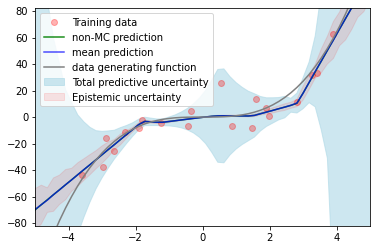

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc, _ = network(X_test)

    predictions, mean, var, noises, metrics = network.predict_dist(
        X_test, n_predictions,
        y_test=y_test,
        tau=torch.tensor(tau, dtype=torch.float))
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    noises = noises.cpu()

    total_uncertainty = var + noises

    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    print("Noise = " + str(noises.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for metric_key, value in metrics.items():
            print(str(metric_key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low-1, dataset_toy_x_high+1)
    
    plot_ylim_low = dataset_toy_x_low ** 3 - 2 * dataset_toy_y_noise_std
    plot_ylim_high = dataset_toy_x_high ** 3 + 2 * dataset_toy_y_noise_std
    
    plt.ylim(plot_ylim_low, plot_ylim_high)
    
    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(total_uncertainty).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(total_uncertainty).detach().numpy()).flatten(),
        color='lightblue', alpha=0.6, label="Total predictive uncertainty")
    
    # epistemic
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='red', alpha=0.1, label="Epistemic uncertainty")

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.9)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.7)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()